In [1]:
import numpy as np
import tensorflow as tf
from codebase.general import *
from codebase.unet_functions import *

In [2]:
file_path = r'datasets/4000.am'
sigma = 20
d = read_am_file(file_path,sigma=sigma)
# encoder_data_history_range = (-30,10+1,10)
encoder_data_history_range = (-40,0+1,10)
slices = [slice(0,1001,1),slice(0,250,1),slice(250,500,1)]
data = loadData(file_path, np.arange(*encoder_data_history_range), gradsBC=True, slices=slices, sigma=sigma)
data_train = data
slices_test = [slice(0,1001,1),slice(250,500,1),slice(250,500,1)]
data_test = loadData(file_path, np.arange(*encoder_data_history_range), gradsBC=True, slices=slices_test, sigma=sigma)

n_grid = 16
x = np.linspace(0,1,n_grid)
X,Y = np.meshgrid(x,x)
nodes = np.stack([X,Y],-1)


n_skip = 30
n_max = 0
X_train = np.stack([GetX(data_train[i]) for i in range(0,len(data)-n_max,n_skip)],axis=0)
Y_train = np.stack([data_train[i]['interpSD'](nodes) for i in range(0,len(data)-n_max,n_skip)],axis=0)
x_mean,x_std = X_train.mean((0,1,2),keepdims=True), X_train.std((0,1,2),keepdims=True)
y_mean,y_std = Y_train.mean((0,1,2),keepdims=True), Y_train.std((0,1,2),keepdims=True)
X_train = (X_train-x_mean)/x_std

X_test = np.stack([GetX(data_test[i]) for i in range(0,len(data),100)],axis=0)
Y_test = np.stack([data_test[i]['interpSD'](nodes) for i in range(0,len(data),100)],axis=0)
X_test = (X_test-x_mean)/x_std

(1001, 250, 250, 2)
(1001, 250, 250, 2)


In [3]:
layer_sizes = np.array((1,2,4))*128
model = unet(input_shape=X_train.shape[1:], layer_sizes=layer_sizes)

# Compile the model with an appropriate optimizer and loss function for regression
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.3e-3),
    loss='mse',             # Mean Squared Error for regression
    metrics=['mae']         # Mean Absolute Error as an additional metric
)

# Train the model
history = model.fit(
    X_train, Y_train,
    batch_size=32,          # Adjust batch size as needed
    epochs=100,             # Adjust the number of epochs based on your needs
    validation_data=(X_test, Y_test),
    shuffle=True,
    verbose=1               # Set to 1 or 2 for more/less verbose output
)

Epoch 1/100
2/2 [==============================] - 0s 103ms/step - loss: 0.9202 - mae: 0.7773 - val_loss: 0.4389 - val_mae: 0.5475
Epoch 2/100
2/2 [==============================] - 0s 36ms/step - loss: 0.4144 - mae: 0.4837 - val_loss: 0.2487 - val_mae: 0.3871
Epoch 3/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1803 - mae: 0.3253 - val_loss: 0.3132 - val_mae: 0.4476
Epoch 4/100
2/2 [==============================] - 0s 44ms/step - loss: 0.2247 - mae: 0.3614 - val_loss: 0.2527 - val_mae: 0.3936
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 0.1957 - mae: 0.3358 - val_loss: 0.2072 - val_mae: 0.3591
Epoch 6/100
2/2 [==============================] - 0s 40ms/step - loss: 0.1672 - mae: 0.3266 - val_loss: 0.1896 - val_mae: 0.3386
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 0.1411 - mae: 0.2878 - val_loss: 0.2058 - val_mae: 0.3476
Epoch 8/100
2/2 [==============================] - 0s 38ms/step - loss: 0.1216 - mae: 0.2

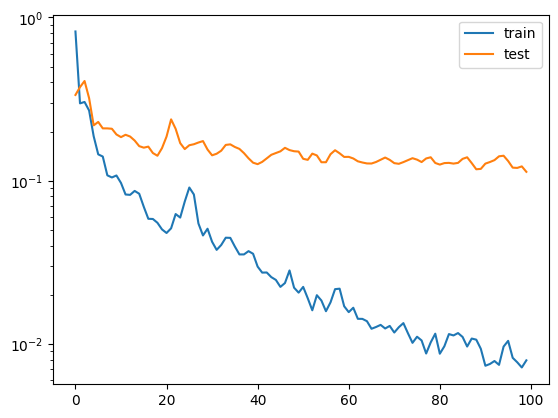

In [18]:
plt.plot(history.history['loss'][:],label='train')
plt.plot(history.history['val_loss'][:],label='test')
plt.legend()
plt.gca().set_yscale('log')

In [19]:
X_test = np.stack([GetX(data_test[i]) for i in range(0,len(data),5)],axis=0)
Y_test = np.stack([data_test[i]['interpSD'](nodes) for i in range(0,len(data),5)],axis=0)

X_test = (X_test-x_mean)/x_std
Y_test_pred = model(X_test)

The validation err for UNET model is: 0.11327842622995377


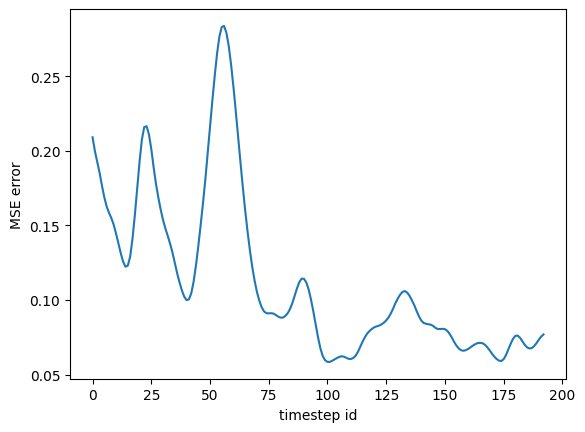

In [21]:
err = np.mean(np.square(Y_test_pred-Y_test),axis=(1,2,3))
plt.plot(err)
plt.xlabel('timestep id')
plt.ylabel('MSE error')
print(f"The validation err for UNET model is: {np.mean(err)}")